In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [3]:
n_steps=100
time=np.pi/3
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[-0.5 - 0.866*I,                    0,                    0,                  0,                  0,                    0,                    0,              0],
[             0,       0.25 - 0.433*I,   0.00453 - 0.0079*I,                  0,   -0.755 - 0.425*I,                    0,                    0,              0],
[             0, -0.00454 + 0.00781*I,       -0.5 - 0.866*I,                  0, 0.00453 - 0.0079*I,                    0,                    0,              0],
[             0,                    0,                    0,     0.25 - 0.433*I,                  0, -0.00454 + 0.00781*I,     -0.745 - 0.441*I,              0],
[             0,     -0.745 - 0.441*I, -0.00454 + 0.00781*I,                  0,     0.25 - 0.433*I,                    0,                    0,              0],
[             0,                    0,                    0, 0.00453 - 0.0079*I,                  0,       -0.5 - 0.866*I, -0.00454 + 0.00781*I,              0],
[             0,   

In [4]:
B = Matrix([
    [0,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1]
])
B

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 1]])

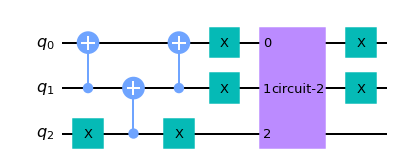

In [5]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

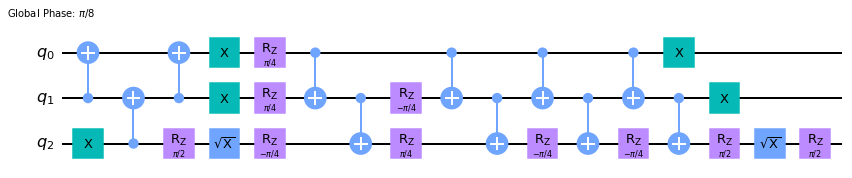

In [6]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [7]:
n_steps = 42
time = np.pi
precision = 40

numeric_evolution_matrix=eye(8)

#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[    0.24994 - 0.43297*I, -0.0045427 + 0.0078115*I,      -0.7454 - 0.44087*I,                0],
[0.0045267 - 0.0078972*I,     -0.49998 - 0.86594*I, -0.0045427 + 0.0078115*I,                0],
[   -0.75447 - 0.42516*I,  0.0045267 - 0.0078972*I,      0.24994 - 0.43297*I,                0],
[                      0,                        0,                        0, -0.5 - 0.86602*I]])

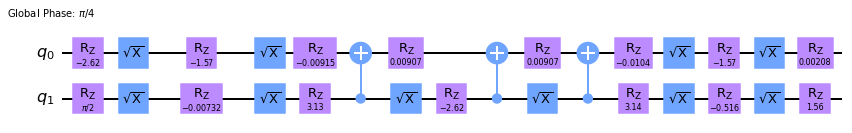

In [8]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

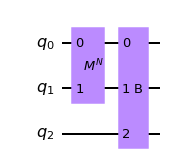

In [9]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr[0],qr[1]])
qc_U.append(B_qc,[qr[0],qr[1],qr[2]])

qc_U.draw(output="mpl")

In [10]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[                             0,                             0,                              0,                             0, -0.2499422916 + 0.4329694557*I, 0.0045592696 - 0.0078210434*I,  0.7453995018 + 0.4408672454*I,      -1.66738e-5 + 9.396e-6*I],
[ 0.7544691345 + 0.4251588751*I, -0.004510263 + 0.0078875014*I, -0.2499422949 + 0.4329694559*I,      -1.6577e-5 + 9.5707e-6*I,                              0,                             0,                              0,                             0],
[-0.0045101626 + 0.0078876741*I, 0.4999840448 + 0.8659396308*I,  0.0045593697 - 0.0078208688*I,          9.82e-8 + 1.743e-7*I,                              0,                             0,                              0,                             0],
[-0.2499422916 + 0.4329694557*I, 0.0045592696 - 0.0078210434*I,  0.7453995018 + 0.4408672454*I,      -1.66738e-5 + 9.396e-6*I,                              0,                             0,                              0,        

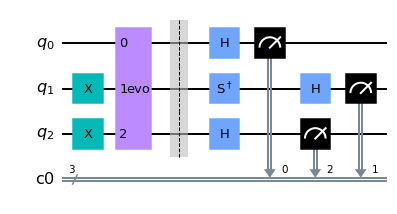

In [11]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [12]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [13]:
cal_circ[0].draw()

░ ┌─┐      
q66_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q66_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q66_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [14]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [16]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q70_0: ┤ X ├┤0     ├─────┤M├──────
       ├───┤│      │┌───┐└╥┘┌─┐   
q70_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
       ├───┤│      │├───┤ ║ └╥┘┌─┐
q70_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
       └───┘└──────┘└───┘ ║  ║ └╥┘
 c5: 3/═══════════════════╩══╩══╩═
                          0  1  2

In [17]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q69_0: ┤ X ├┤0     ├┤M├──────
       └───┘│      │└╥┘┌─┐   
q69_1: ─────┤1 evo ├─╫─┤M├───
            │      │ ║ └╥┘┌─┐
q69_2: ─────┤2     ├─╫──╫─┤M├
            └──────┘ ║  ║ └╥┘
 c4: 3/══════════════╩══╩══╩═
                     0  1  2

In [18]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [19]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [20]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[0.94278125, 0.04878125, 0.03434375, 0.00140625, 0.03078125, 0.00159375, 0.00128125, 0.00015625],
[0.01834375,  0.9125625, 0.00059375, 0.03203125,  0.0006875,  0.0298125,          0,   0.001375],
[0.01040625, 0.00059375,  0.9174375, 0.04909375,  0.0001875,   3.125e-5, 0.03159375,   0.001375],
[0.00040625, 0.00996875,   0.017625,      0.889,          0,  0.0003125, 0.00059375, 0.03003125],
[ 0.0273125,  0.0011875,  0.0013125,   0.000125,  0.9378125,     0.0505,  0.0345625,   0.001625],
[0.00040625, 0.02671875,          0,  0.0008125, 0.01865625, 0.90703125,     0.0005, 0.03303125],
[0.00034375,   3.125e-5, 0.02809375,   0.001375,     0.0115, 0.00071875,   0.913625, 0.04853125],
[         0, 0.00015625, 0.00059375, 0.02615625,   0.000375,       0.01, 0.01784375,   0.883875]])

In [21]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[  0.891125,   0.061625, 0.04278125,  0.0039375,  0.0401875, 0.00309375,    0.00325,  0.0130625],
[ 0.0315625,  0.8649375,   0.002625, 0.04109375, 0.00228125,  0.0401875,  0.0124375, 0.00296875],
[0.02303125,  0.0019375,  0.8713125,   0.062875, 0.00240625,   0.012625, 0.03834375,   0.002625],
[ 0.0013125, 0.02065625,  0.0306875, 0.83940625,   0.014375,  0.0019375,    0.00175, 0.03721875],
[0.03646875,      0.003, 0.00234375, 0.01315625, 0.88596875,  0.0613125,    0.04375, 0.00403125],
[  0.001625,   0.034125,    0.01275,   0.002875,   0.032125,  0.8575625, 0.00184375,     0.0415],
[ 0.0024375,   0.012125,  0.0358125, 0.00278125,  0.0211875,  0.0018125,      0.867, 0.06140625],
[ 0.0124375, 0.00159375,  0.0016875,   0.033875, 0.00146875, 0.02146875,   0.031625,  0.8371875]])

In [22]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [23]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [24]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1370_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1370_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1370_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c18: 3/══════╩════════════════╩══╩═
               1                0  2

In [25]:
meas_fitter_qiskit.cal_matrix

array([[9.4278125e-01, 4.8781250e-02, 3.4343750e-02, 1.4062500e-03,
        3.0781250e-02, 1.5937500e-03, 1.2812500e-03, 1.5625000e-04],
       [1.8343750e-02, 9.1256250e-01, 5.9375000e-04, 3.2031250e-02,
        6.8750000e-04, 2.9812500e-02, 0.0000000e+00, 1.3750000e-03],
       [1.0406250e-02, 5.9375000e-04, 9.1743750e-01, 4.9093750e-02,
        1.8750000e-04, 3.1250000e-05, 3.1593750e-02, 1.3750000e-03],
       [4.0625000e-04, 9.9687500e-03, 1.7625000e-02, 8.8900000e-01,
        0.0000000e+00, 3.1250000e-04, 5.9375000e-04, 3.0031250e-02],
       [2.7312500e-02, 1.1875000e-03, 1.3125000e-03, 1.2500000e-04,
        9.3781250e-01, 5.0500000e-02, 3.4562500e-02, 1.6250000e-03],
       [4.0625000e-04, 2.6718750e-02, 0.0000000e+00, 8.1250000e-04,
        1.8656250e-02, 9.0703125e-01, 5.0000000e-04, 3.3031250e-02],
       [3.4375000e-04, 3.1250000e-05, 2.8093750e-02, 1.3750000e-03,
        1.1500000e-02, 7.1875000e-04, 9.1362500e-01, 4.8531250e-02],
       [0.0000000e+00, 1.5625000e-04, 5.9

In [26]:
C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [27]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [28]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [29]:
raw_res.get_counts(-1)

{'101': 446,
 '011': 87,
 '111': 487,
 '110': 7135,
 '100': 1113,
 '001': 545,
 '010': 740,
 '000': 21447}

In [30]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [31]:
qiskit_res.get_counts(-1)

{'000': 22713.751085613632,
 '001': 122.6669292084361,
 '010': 277.37892737866343,
 '011': 62.19135622263497,
 '100': 213.25439620664054,
 '101': 455.1146263845855,
 '110': 7768.784724854141,
 '111': 386.8579541312636}

In [32]:
itself_res.get_counts(-1)

{'000': 32000.0, '110': 0.22309926336023794}

In [33]:
identity_res.get_counts(-1)

{'000': 23829.040022209247,
 '001': 7.228068217795152e-08,
 '010': 2.4400952394119447e-08,
 '011': 6.366360637851005e-11,
 '100': 2.5698301118358706e-08,
 '101': 226.06529604758725,
 '110': 7944.894681619895,
 '111': 8.079580261745787e-09}

In [34]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.22265018, 0.24232849, 0.24212155, 0.20610262])

In [35]:
occurrences_to_vector(identity_res.get_counts(-1))

array([2.38290400e+04, 7.22806822e-08, 2.44009524e-08, 6.36636064e-11,
       2.56983011e-08, 2.26065296e+02, 7.94489468e+03, 8.07958026e-09])